# IMPORT

In [ ]:
# import necessary modules
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import balanced_accuracy_score

В файле merge.xlsx имеются данные из нашего датасета и датасета OASIS.

Целевой столбец - Emotion, возможные классы 1, 2, 3, 4, 5.

In [ ]:
oasis = pd.read_excel('merge.xlsx')

print(oasis)

        FPOGD      LPMM      RPMM           GSR         HR  Emotion
0    0.225395  3.549619  3.605054  5.658043e+05  70.222986        3
1    0.251428  3.577045  3.628392  1.038846e+06  65.549374        3
2    0.252400  3.688393  3.714278  7.516777e+05  70.613848        4
3    0.246930  3.640255  3.632712  8.532527e+05  81.566096        2
4    0.217537  3.676866  3.727907  7.838965e+05  72.143997        3
..        ...       ...       ...           ...        ...      ...
115  0.199789  3.585332  3.668141  5.789144e+05  74.083333        3
116  0.245328  3.495562  3.530132  5.212563e+05  73.732501        3
117  0.256034  3.387939  3.484730  3.676240e+05  47.379193        3
118  0.242346  3.469707  3.552657  9.646409e+05  81.422226        3
119  0.194841  3.547724  3.618649  6.702625e+05  87.445223        4

[120 rows x 6 columns]


# PRELIMINARY DATA ANALYSIS

3 24 46 36 11


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


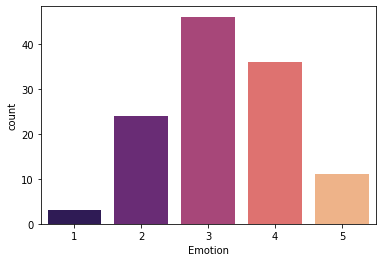

In [ ]:
count_1 = len(oasis[oasis['Emotion'] == 1.0])
count_2 = len(oasis[oasis['Emotion'] == 2.0])
count_3 = len(oasis[oasis['Emotion'] == 3.0])
count_4 = len(oasis[oasis['Emotion'] == 4.0])
count_5 = len(oasis[oasis['Emotion'] == 5.0])

print(count_1, count_2, count_3, count_4, count_5)

sns.countplot(oasis['Emotion'], palette='magma');

***Вывод***: классы не сбалансированы. Необходимо улучшить выборку, добавив экземпляры 1 и 5-го классов. В противном случае будут хорошо определяться только классы 2, 3 и 4, а 1 и 5 в рамках случайного выброса.

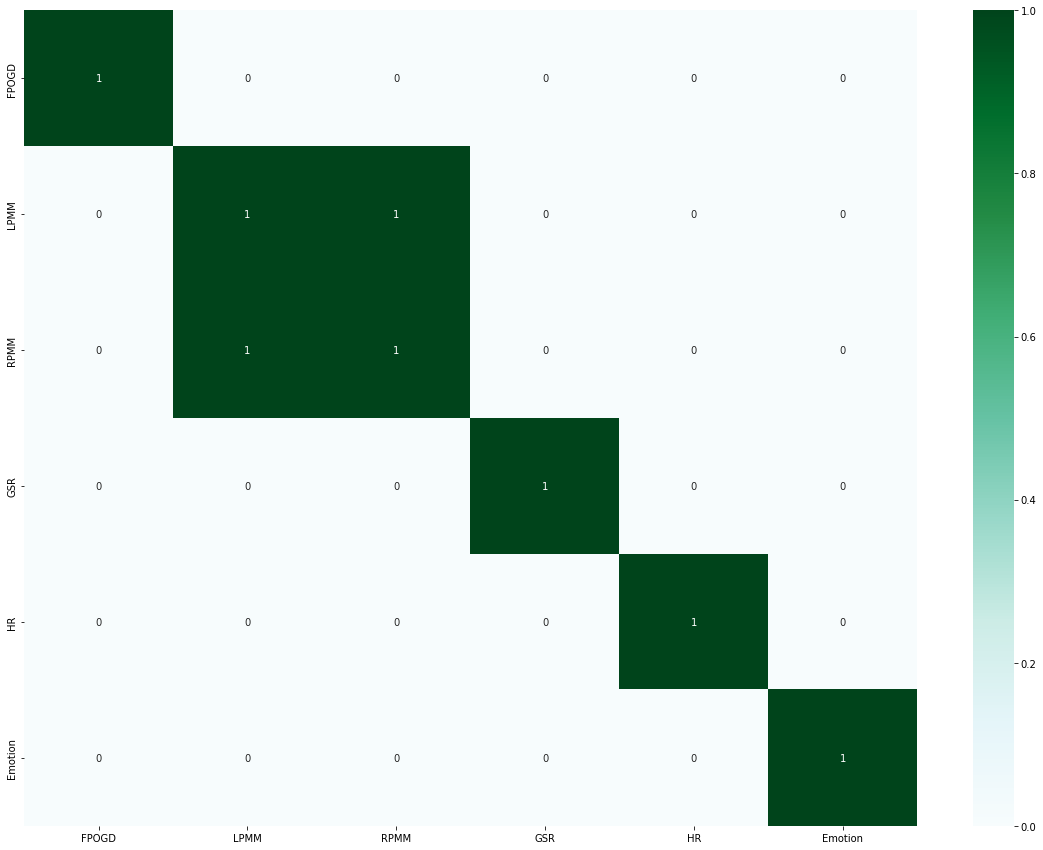

In [ ]:
catcol = []
catcol.append('FPOGD')
catcol.append('LPMM')
catcol.append('RPMM')
catcol.append('GSR')
catcol.append('HR')

fig, ax = plt.subplots(figsize=(20, 15))
corrmat1 = abs(oasis[catcol + ['Emotion']].corr())

sns.heatmap(corrmat1>0.7, vmin=0, vmax=1, annot=True, cmap='BuGn');

***Вывод:*** сильно скоррелированны столбцы LPMM и RPMM, следовательно, можно один из столбцов удалить.


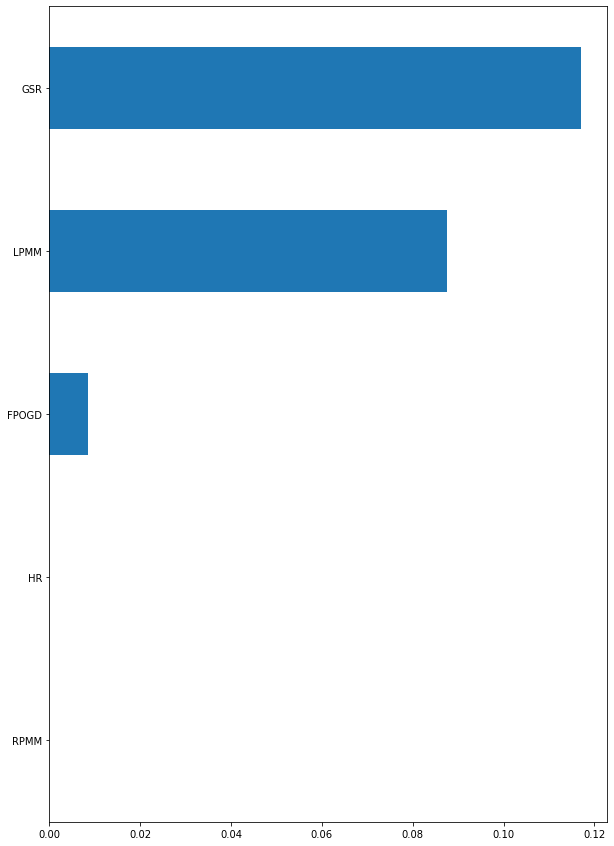

In [ ]:
fig, ax = plt.subplots(figsize=(10,15))
imp_cat = pd.Series(mutual_info_classif(oasis[catcol], oasis['Emotion']), index=catcol)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh');

***Вывод:*** наибольший вклад в итоговое решение вносят GSR и LPMM.


# MODEL

In [ ]:
X = oasis.drop('Emotion', axis=1)
y = oasis['Emotion']

X.shape, y.shape

((120, 5), (120,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((96, 5), (24, 5), (96,), (24,))

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

In [ ]:
model_0 = CatBoostClassifier(auto_class_weights='Balanced', 
                          random_seed = 42,
                          custom_metric='Accuracy',
                          boosting_type="Ordered", learning_rate=0.1,
                          silent=True)
model_0.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         early_stopping_rounds=20,
         use_best_model=True,
         )

predict_0 = model_0.predict(X_test)
print(f"Точность модели по метрике balanced_accuracy_score:{(balanced_accuracy_score(y_test, predict_0))*100:0.2f}%")

Точность модели по метрике balanced_accuracy_score:58.72%


Точность модели, обученной CatBoostClassifier - 58,72%

Размер тестовой выборки - 20%

# OTHER CLASSIFIERS

In [ ]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.23.1

Found existing installation: scikit-learn 0.23.1
Uninstalling scikit-learn-0.23.1:
  Successfully uninstalled scikit-learn-0.23.1
  Using cached scikit_learn-0.23.1-cp37-cp37m-manylinux1_x86_64.whl (6.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.1 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.1 which is incompatible.


In [ ]:
!pip install lazypredict
import lazypredict
import lazypredict.Supervised
from lazypredict.Supervised import LazyClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:00<00:00, 29.65it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.25,0.50,None,0.22,0.02
SGDClassifier,0.25,0.34,None,0.23,0.02
LabelPropagation,0.46,0.29,None,0.49,0.02
Perceptron,0.46,0.27,None,0.43,0.01
LabelSpreading,0.42,0.27,None,0.45,0.01
KNeighborsClassifier,0.42,0.25,None,0.40,0.02
LinearSVC,0.42,0.24,None,0.34,0.02
LogisticRegression,0.42,0.24,None,0.34,0.02
SVC,0.42,0.24,None,0.35,0.01


Другие классификаторы показывают качество хуже, чем CatBoost.

# SUMMARY

1. Качество модели улучшается при увеличении выборки для обучения модели, следовательно, чем больше данных - тем лучший результат покажет модель.
2. Необходимо добавить данные по классам 1 и 5.
3. Поскольку модель сейчас обучается на трех фичах, можно из имеющихся данных придумать другие фичи, связанные с эмоциями.